# 要件定義書生成AIエージェント
* 『LangChainとLangGraphによるRAG・AIエージェント実践入門（10章より)』
* 「要件定義書」を自動生成するエージェントの作成から、LangGraphによるマルチエージェント作成を学ぶ

## 要件定義のプロセス
『ステークホルダーの特定』→『情報収集』→『要求の分析と整理』→『要求の文書化』→『検証と妥当性確認』

* ここでは、Elicitronの対話エージェントを参考に作成

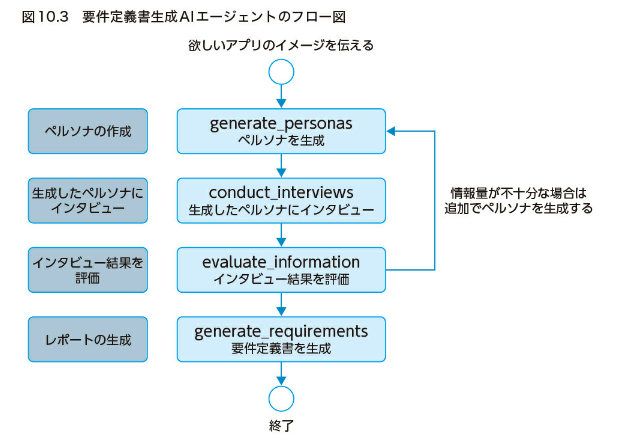

In [14]:
from IPython.display import Image
Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/agent_flow.png")

追加対策：  
1. まず、５名のペルソナに対してインタビューを行う
2. インタビュー結果を評価し、情報が足りないと判断した場合
    a. 追加で５名分のペルソナを作成する
    b. 新しく作成したペルソナに対して追加インタビューを行う
    c. 2に戻り、インタビューの結果の十分性を再評価する

In [1]:
# !pip install langchain-core==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 python-dotenv==1.0.1

In [ ]:
# !pip install "pydantic<2.11"  # 例: 2.10.6 エラー回避用

In [ ]:
from dotenv import load_dotenv
load_dotenv()

In [ ]:
# import os

# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
# os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT

In [ ]:
import operator
from typing import Annotated, Any, Optional

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import  ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from pydantic import Field, BaseModel

* Pydanticを用いることで各フィールドの型が明確に定義され、誤った型のデータが代入されるのを防ぐとともに、LangChainの`with_structured_output`関数と併用することで、任意の型に合ったデータをLLMに生成させることが可能になる。
* `with_structured_output`で正しくデータを生成するためには、各フィールドへの説明が適切に設定されている必要がある。
  
<br>

## データモデルの定義

In [ ]:
# ペルソナを表すデータモデル
class Persona(BaseModel):
    name: str = Field(..., description="ペルソナの名前")
    background: str = Field(..., description="ペルソナの持つ背景")


# ペルソナのリストを表すデータモデル
class Personas(BaseModel):
    personas: list[Persona] = Field(
        default_factory=list, description="ペルソナのリスト"
    )


# インタビュー内容を表すデータモデル
class Interview(BaseModel):
    persona: Persona = Field(..., description="インタビュー対象のペルソナ")
    question: str = Field(..., description="インタビューでの質問")
    answer: str = Field(..., description="インタビューでの回答")


# インタビュー結果のリストを表すデータモデル
class InterviewResult(BaseModel):
    interviews: list[Interview] = Field(
        default_factory=list, description="インタビュー結果のリスト"
    )


# 評価の結果を表すデータモデル
class EvaluationResult(BaseModel):
    reason: str = Field(..., description="判断の理由")
    is_sufficient: bool = Field(..., description="情報が十分かどうか")

## ステート定義
* personasとinterviewsフィールドはノードによってデータが追加されていく項目になるため、Annotatedとoperator.addを用いて定義

In [ ]:
# 要件定義生成AIエージェントのステート
class InterviewState(BaseModel):
    user_request: str = Field(..., description="ユーザーからのリクエスト")
    personas: Annotated[list[Persona], operator.add] = Field(
        default_factory=list, description="生成されたペルソナのリスト"
    )
    interviews: Annotated[list[Interview], operator.add] = Field(
        default_factory=list, description="実施されたインタビューのリスト"
    )
    requirements_doc: str = Field(default="", description="生成された要件定義")
    iteration: int = Field(
        default=0, description="ペルソナ生成とインタビューの反復回数"
    )
    is_information_sufficient: bool = Field(
        default=False, description="情報が十分かどうか"
    )

## 主要コンポーネントの実装
* PersonaGenerator: ペルソナを生成する
* InterviewConductor: ペルソナにインタビューを実施する
* InformationEvaluator: 収集した情報の十分性を評価する
* RequirementsDocumentGenerator: 要件定義書を作成する

### PersonaGenerator
* PersonaGeneratorクラスは、ユーザーの要求に基づいて多様なペルソナを生成する。
* 生成するペルソナの人数は、kパラメータによって制御できるようにする。

In [ ]:
class PersonaGenerator:
    def __init__(self, llm: ChatOpenAI, k: int = 5):
        self.llm = llm.with_structured_output(Personas)
        self.k = k

    def run(self, user_request: str) -> Personas:
        # プロンプトテンプレートを定義
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたはユーザーインタビュー用の多様なペルソナを作成する専門家です。",
                ),
                (
                    "human",
                    f"以下のユーザーリクエストに関するインタビュー用に、{self.k}人の多様なペルソナを生成してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n\n"
                    "各ペルソナには名前と簡単な背景を含めてください。年齢、性別、職業、技術的専門知識において多様性を確保してください。",
                ),
            ]
        )
        # ペルソナ生成のためのチェーンを作成
        chain = prompt | self.llm
        # ペルソナを生成
        return chain.invoke({"user_request": user_request})

### InterviewConductor
生成されたペルソナに対してインタビューを実施する  

* `_generate_questions`関数：各ペルソナに対する質問を生成する
* `_generate_answers`関数：各質問に対する回答を生成する
* `_create_interviews`関数：ペルソナ、質問、回答を組み合わせてInterviewオブジェクトを生成する
* `run`関数：上記３つのステップを順番に実行し、最終的なインタビュー結果を返す

<br>


* `_generate_questions`関数と`_generate_answers`関数では、batch関数を用いて、複数のペルソナに対する質問生成や回答生成を同時に行っている。注意点として、2024/8時点で、batch関数は入力リストに対して、出力リストの順序も保証される実装だが、ドキュメントには明記されていない。

In [ ]:
# インタビューを実施するクラス
class InterviewConductor:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, user_request: str, personas: list[Persona]) -> InterviewResult:
        # 質問を生成
        questions = self._generate_questions(
            user_request=user_request, personas=personas
        )
        # 回答を生成
        answers = self._generate_answers(personas=personas, questions=questions)
        # 質問と回答の組み合わせからインタビューリストを作成
        interviews = self._create_interviews(
            personas=personas, questions=questions, answers=answers
        )
        # インタビュー結果を返す
        return InterviewResult(interviews=interviews)

    def _generate_questions(
        self, user_request: str, personas: list[Persona]
    ) -> list[str]:
        # 質問生成のためのプロンプトを定義
        question_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたはユーザー要件に基づいて適切な質問を生成する専門家です。",
                ),
                (
                    "human",
                    "以下のペルソナに関連するユーザーリクエストについて、1つの質問を生成してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n"
                    "ペルソナ: {persona_name} - {persona_background}\n\n"
                    "質問は具体的で、このペルソナの視点から重要な情報を引き出すように設計してください。",
                ),
            ]
        )
        # 質問生成のためのチェーンを作成
        question_chain = question_prompt | self.llm | StrOutputParser()

        # 各ペルソナに対する質問クエリを作成
        question_queries = [
            {
                "user_request": user_request,
                "persona_name": persona.name,
                "persona_background": persona.background,
            }
            for persona in personas
        ]
        # 質問をバッチ処理で生成
        return question_chain.batch(question_queries)

    def _generate_answers(
        self, personas: list[Persona], questions: list[str]
    ) -> list[str]:
        # 回答生成のためのプロンプトを定義
        answer_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたは以下のペルソナとして回答しています: {persona_name} - {persona_background}",
                ),
                ("human", "質問: {question}"),
            ]
        )
        # 回答生成のためのチェーンを作成
        answer_chain = answer_prompt | self.llm | StrOutputParser()

        # 各ペルソナに対する回答クエリを作成
        answer_queries = [
            {
                "persona_name": persona.name,
                "persona_background": persona.background,
                "question": question,
            }
            for persona, question in zip(personas, questions)
        ]
        # 回答をバッチ処理で生成
        return answer_chain.batch(answer_queries)

    def _create_interviews(
        self, personas: list[Persona], questions: list[str], answers: list[str]
    ) -> list[Interview]:
        # ペルソナ毎に質問と回答の組み合わせからインタビューオブジェクトを作成
        return [
            Interview(persona=persona, question=question, answer=answer)
            for persona, question, answer in zip(personas, questions, answers)
        ]

### InformationEvaluator
収集した情報が要件定義書を生成するために十分かどうかを評価する

In [ ]:
# 情報の十分性を評価するクラス
class InformationEvaluator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm.with_structured_output(EvaluationResult)

    # ユーザーリクエストとインタビュー結果を基に情報の十分性を評価
    def run(self, user_request: str, interviews: list[Interview]) -> EvaluationResult:
        # プロンプトを定義
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたは包括的な要件文書を作成するための情報の十分性を評価する専門家です。",
                ),
                (
                    "human",
                    "以下のユーザーリクエストとインタビュー結果に基づいて、包括的な要件文書を作成するのに十分な情報が集まったかどうかを判断してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n\n"
                    "インタビュー結果:\n{interview_results}",
                ),
            ]
        )
        # 情報の十分性を評価するチェーンを作成
        chain = prompt | self.llm
        # 評価結果を返す
        return chain.invoke(
            {
                "user_request": user_request,
                "interview_results": "\n".join(
                    f"ペルソナ: {i.persona.name} - {i.persona.background}\n"
                    f"質問: {i.question}\n回答: {i.answer}\n"
                    for i in interviews
                ),
            }
        )

### RequirementsDocumentGenerator
ユーザー要求とインタビュー結果に基づいて、最終的な要件定義書を生成する

In [ ]:
# 要件定義書を生成するクラス
class RequirementsDocumentGenerator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, user_request: str, interviews: list[Interview]) -> str:
        # プロンプトを定義
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたは収集した情報に基づいて要件文書を作成する専門家です。",
                ),
                (
                    "human",
                    "以下のユーザーリクエストと複数のペルソナからのインタビュー結果に基づいて、要件文書を作成してください。\n\n"
                    "ユーザーリクエスト: {user_request}\n\n"
                    "インタビュー結果:\n{interview_results}\n"
                    "要件文書には以下のセクションを含めてください:\n"
                    "1. プロジェクト概要\n"
                    "2. 主要機能\n"
                    "3. 非機能要件\n"
                    "4. 制約条件\n"
                    "5. ターゲットユーザー\n"
                    "6. 優先順位\n"
                    "7. リスクと軽減策\n\n"
                    "出力は必ず日本語でお願いします。\n\n要件文書:",
                ),
            ]
        )
        # 要件定義書を生成するチェーンを作成
        chain = prompt | self.llm | StrOutputParser()
        # 要件定義書を生成
        return chain.invoke(
            {
                "user_request": user_request,
                "interview_results": "\n".join(
                    f"ペルソナ: {i.persona.name} - {i.persona.background}\n"
                    f"質問: {i.question}\n回答: {i.answer}\n"
                    for i in interviews
                ),
            }
        )

## ワークフロー構築
`DocumentationAgent`は、すべてのコンポーネントをつなぎ合わせて、全体のワークフローを管理する。  
このクラスは次の構造をとる：  
* クラスの初期化時に主要コンポーネントである`PersonaGenerator`、`InterviewConductor`、`InformationEvaluator`、`RequestsDocumentGenerator`のインスタンスを作成する。
* `_create_graph`関数で、LangGraphを用いたワークフローを定義する。ペルソナ生成、インタビュー実施、評価、要件定義書作成の各ステップをノードとして定義し、ノード間の遷移をエッジ、条件付きエッジで定義している。
* ノードの実装は、各ステップに対応する関数（`_generate_personas`、`_conduct_interviews`、`_evaluate_information`、`_generate_requirements`）に実装している。これらの関数は対応するステートからコンポーネントに情報を渡し、コンポーネントから受け取った情報をもとにステートを更新する責務を持つ
* エージェントの実行は`run`関数で行う

In [ ]:
# 要件定義書生成AIエージェントのクラス
class DocumentationAgent:
    def __init__(self, llm: ChatOpenAI, k: Optional[int] = None):
        # 各種ジェネレータの初期化
        self.persona_generator = PersonaGenerator(llm=llm, k=k)
        self.interview_conductor = InterviewConductor(llm=llm)
        self.information_evaluator = InformationEvaluator(llm=llm)
        self.requirements_generator = RequirementsDocumentGenerator(llm=llm)

        # グラフの作成
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        # グラフの初期化
        workflow = StateGraph(InterviewState)

        # 各ノードの追加
        workflow.add_node("generate_personas", self._generate_personas)
        workflow.add_node("conduct_interviews", self._conduct_interviews)
        workflow.add_node("evaluate_information", self._evaluate_information)
        workflow.add_node("generate_requirements", self._generate_requirements)

        # エントリーポイントの設定
        workflow.set_entry_point("generate_personas")

        # ノード間のエッジの追加
        workflow.add_edge("generate_personas", "conduct_interviews")
        workflow.add_edge("conduct_interviews", "evaluate_information")

        # 条件付きエッジの追加
        workflow.add_conditional_edges(
            "evaluate_information",
            lambda state: not state.is_information_sufficient and state.iteration < 5,
            {True: "generate_personas", False: "generate_requirements"},
        )
        workflow.add_edge("generate_requirements", END)

        # グラフのコンパイル
        return workflow.compile()

    def _generate_personas(self, state: InterviewState) -> dict[str, Any]:
        # ペルソナの生成
        new_personas: Personas = self.persona_generator.run(state.user_request)
        return {
            "personas": new_personas.personas,
            "iteration": state.iteration + 1,
        }

    def _conduct_interviews(self, state: InterviewState) -> dict[str, Any]:
        # インタビューの実施
        new_interviews: InterviewResult = self.interview_conductor.run(
            state.user_request, state.personas[-5:]
        )
        return {"interviews": new_interviews.interviews}

    def _evaluate_information(self, state: InterviewState) -> dict[str, Any]:
        # 情報の評価
        evaluation_result: EvaluationResult = self.information_evaluator.run(
            state.user_request, state.interviews
        )
        return {
            "is_information_sufficient": evaluation_result.is_sufficient,
            "evaluation_reason": evaluation_result.reason,
        }

    def _generate_requirements(self, state: InterviewState) -> dict[str, Any]:
        # 要件定義書の生成
        requirements_doc: str = self.requirements_generator.run(
            state.user_request, state.interviews
        )
        return {"requirements_doc": requirements_doc}

    def run(self, user_request: str) -> str:
        # 初期状態の設定
        initial_state = InterviewState(user_request=user_request)
        # グラフの実行
        final_state = self.graph.invoke(initial_state)
        # 最終的な要件定義書の取得
        return final_state["requirements_doc"]

## 実行

In [ ]:
k = 5
user_request = "様々な支払方法（電子マネー、QRコード、クレジットカード、現金...)をまとめて管理できるスマホ家計簿アプリを開発したい"

In [ ]:
# ChatOpenAIモデルの初期化
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

# 要件定義書生成AIエージェントの初期化
agent = DocumentationAgent(llm=llm, k=k)

# エージェントを実行して最終的な出力を取得
final_output = agent.run(user_request=user_request)

print(final_output)

# 要件文書

## 1. プロジェクト概要
本プロジェクトは、様々な支払方法（電子マネー、QRコード、クレジットカード、現金など）を一元管理できるスマホ家計簿アプリの開発を目的としています。このアプリは、ユーザーが日常的に利用する多様な支払い方法を簡単に管理し、支出の可視化と効率的な家計管理をサポートします。

## 2. 主要機能
1. **自動連携機能**: 銀行口座、クレジットカード、電子マネー、PayPal、仮想通貨ウォレットなどと自動で連携し、取引データを自動的に取り込む。
2. **カテゴリー分けの柔軟性**: 支出を細かくカテゴリー分けでき、カスタムカテゴリーの作成が可能。
3. **レポート機能**: 月次や年次で支出の傾向をグラフやチャートで視覚的に確認可能。
4. **予算設定とアラート機能**: 各カテゴリーごとに予算を設定し、予算を超えそうなときにアラートを出す。
5. **レシート撮影機能**: レシートを撮影してデータ化し、OCR機能で自動的に内容を読み取る。
6. **多通貨対応**: 異なる通貨での支出も管理可能。
7. **音声入力**: 音声で支出を入力できる機能。
8. **シンプルで直感的なインターフェース**: 初心者でも使いやすいデザイン。
9. **タグ付け機能**: 支払いの詳細をタグ付けし、プロジェクトやクライアントごとに管理。
10. **リマインダー機能**: 支払いの遅れがあるクライアントをリマインド。

## 3. 非機能要件
1. **セキュリティ**: 指紋認証や顔認証によるロック解除、データの暗号化。
2. **パフォーマンス**: 大量のデータを扱う際もスムーズに動作する。
3. **ユーザビリティ**: 直感的で使いやすいUI/UX。
4. **サポート体制**: 問い合わせに迅速に対応できるサポート。

## 4. 制約条件
1. **プラットフォーム**: iOSおよびAndroidでの動作を保証。
2. **データ連携**: 各金融機関や電子マネーサービスとのAPI連携が可能であること。
3. **法令遵守**: 金融データを扱うため、関連する法令を遵守する。

## 5. ターゲットユーザー
- 中小企業の経理担当者
- フリーランスのデザイナー
- 年金生活者
- 家計を管理する主婦
-

# GPTによるコード解説

以下では、提示されたコード全体を **「データモデル定義 → ユースケース別チェーン構築 → LangGraph でのノード／エッジ設計 → CLI 実行」** の流れで段階的に解説します。各ステップで使われている Pydantic／LangChain／LangGraph API の役割や相互作用が追えるように、要点とコード断片を交互に示します。

## まとめ

1. **Pydantic `BaseModel`** で人物（ペルソナ）やインタビュー結果などを型安全にスキーマ化し、LangChain の LLM 出力や LangGraph のステートに使い回す。([docs.pydantic.dev][1])
2. **LangChain チェーン**は `ChatPromptTemplate → ChatOpenAI → StrOutputParser` の直列パイプで “生成タスク” を担当し、`with_structured_output` で LLM から直接 Pydantic モデルを返す。([python.langchain.com][2], [python.langchain.com][3])
3. **LangGraph** では `StateGraph` にノード関数を登録し、`Annotated[..., operator.add]` でリスト型フィールドをリデューサー付きマージ（並列更新でも重複せず蓄積）する。([blog.langchain.dev][4], [reddit.com][5])
4. 入口ノード→インタビュー→評価→条件分岐→要件生成→`END` と進むワークフローを記述し、`graph.invoke(initial_state)` で一括実行できる。([langchain-ai.github.io][6], [medium.com][7])

---

## 1. データモデル定義と Pydantic の役割

### 1.1 基本スキーマ

```python
class Persona(BaseModel):
    name: str = Field(..., description="ペルソナの名前")
    background: str = Field(..., description="ペルソナの持つ背景")
```

* `Field(..., description="…")` で **必須 & 説明** を付与。Pydantic は型変換＋バリデーションを自動実行する。([docs.pydantic.dev][1])
* `InterviewState` の `personas` と `interviews` は

  ```python
  Annotated[list[Persona], operator.add]
  ```

  となっており、LangGraph に「**値が重なったら `operator.add` でリストを結合せよ**」という **リデューサー** を指示している。これにより並列ノードでも履歴が壊れず累積できる。([reddit.com][5])

### 1.2 `default_factory=list`

* Pydantic で可変デフォルトを安全に持つ際は `default_factory=list` を使う（インスタンス間でリスト共有バグを防止）。([stackoverflow.com][8])

---

## 2. LangChain チェーンの構築

### 2.1 `ChatPromptTemplate`

* `from_messages([...])`／`from_template(str)` どちらもメッセージの並びを手軽に宣言できる。([python.langchain.com][9])
* 変数 `{user_request}` などは `.invoke({"user_request": "..."})` で埋め込む。

### 2.2 `with_structured_output`

```python
self.llm = llm.with_structured_output(Personas)
```

* OpenAI の Function-Calling 機能を使い、**モデルが `Personas` 型の JSON を直接返す** ようプロンプト＆関数宣言を自動注入。([python.langchain.com][2])

### 2.3 直列パイプ (`|`) と `StrOutputParser`

* LCEL（LangChain Expression Language）のパイプ演算子で各ステップを合成。出力型は `Runnable`。([python.langchain.com][10])
* 文字列化が必要な最後尾に `StrOutputParser()` を挟むと、`LLMResult` → `str` に変換。([python.langchain.com][3])

### 2.4 バッチ生成

* `question_chain.batch(question_queries)` で **入力リストを並列実行**。LCEL には `.batch` / `.abatch` が用意されている。([python.langchain.com][11])

---

## 3. LangGraph ワークフローの設計

### 3.1 `StateGraph(StateSchema)`

```python
workflow = StateGraph(InterviewState)
```

* ステート型は冒頭で定義した Pydantic モデル。LangGraph は各ノードの戻り dict をマージし Validation。([blog.langchain.dev][4])

### 3.2 ノード追加

```python
workflow.add_node("generate_personas", self._generate_personas)
```

* ノードは **同期関数** でも **Runnable** でも可。戻り dict を state にマージ。

### 3.3 エッジと条件分岐

```python
workflow.add_conditional_edges(
    "evaluate_information",
    lambda s: not s.is_information_sufficient and s.iteration < 5,
    {True: "generate_personas", False: "generate_requirements"},
)
```

* 判定関数が True → ペルソナ生成を再実行、False → 要件生成へ。条件付きエッジは LangGraph の定番パターン。([medium.com][7])

### 3.4 `END` ノード

* `"generate_requirements" → END` で **終点** を示す。`END` は特殊定数。([langchain-ai.github.io][6])

---

## 4. ノード実装の詳細

| ノード名                    | 入力                           | 出力                                               | 補足                                         |
| ----------------------- | ---------------------------- | ------------------------------------------------ | ------------------------------------------ |
| `generate_personas`     | `user_request` & `iteration` | `personas` (Append) / `iteration+1`              | `PersonaGenerator.run` が k 件生成             |
| `conduct_interviews`    | 直前までの `personas`             | `interviews` (Append)                            | `InterviewConductor` が質問→回答→Interview      |
| `evaluate_information`  | `interviews`                 | `is_information_sufficient`, `evaluation_reason` | `with_structured_output(EvaluationResult)` |
| `generate_requirements` | `interviews`                 | `requirements_doc`                               | `RequirementsDocumentGenerator` が最終出力      |

すべてのノードは **戻り値が dict**。キーが `InterviewState` とマッチすれば自動的に Merge / Add が適用される。

---

## 5. CLI ランナーの構成

```python
python -m documentation_agent.main --task "スマホ向け健康管理アプリを開発したい" --k 5
```

1. `ChatOpenAI(model="gpt-4o")` を生成。温度 0 → deterministic。([api.python.langchain.com][12])
2. `DocumentationAgent` に渡し、内部でグラフを組み立て。
3. `initial_state = InterviewState(user_request=task)` を seed とし、`graph.invoke` で終点まで実行。

---

## 6. Annotated + operator.add の動きをコードで見る

```python
from typing import Annotated
import operator

class DemoState(BaseModel):
    msgs: Annotated[list[str], operator.add] = Field(default_factory=list)

g = StateGraph(DemoState)

def node_a(s): return {"msgs": ["A"]}
def node_b(s): return {"msgs": ["B"]}

g.add_node("a", node_a)
g.add_node("b", node_b)
g.add_edge("a", "b")
g.add_edge("b", END)

state = g.compile().invoke(DemoState())   # msgs -> ["A","B"]
```

同じキー `msgs` が 2 つのノードから返っても、リデューサーがリストを連結するため上書きされず履歴が残る。

---

## 7. まとめと拡張アイデア

* **Retry / Guardrails**︰`InformationEvaluator` で NG→再実行の条件付きエッジは LangGraph の典型的ループ制御。メタ的に「最大 5 回」も state で管理。
* **並列化**︰`_generate_questions` / `_generate_answers` で `.batch` を使い、複数ペルソナを同時処理。LCEL のランナブルは内部で asyncio / threading を使い自動並列。([python.langchain.com][11])
* **テスト**︰Pydantic により全ノード出力が型検証され、欠落や型不一致を即検出できるため、大規模グラフでも保守が容易。
* **ストレージ**︰`requirements_doc` をファイルに落とすノードを追加すれば、そのまま仕様書ファイル自動生成パイプラインになる。

これらを踏まえれば、LangGraph と Pydantic を組み合わせた **マルチエージェント・ワークフロー** の全体像と、各 API の関係性が理解できるはずです。

[1]: https://docs.pydantic.dev/latest/concepts/fields/?utm_source=chatgpt.com "Fields - Pydantic"
[2]: https://python.langchain.com/docs/how_to/structured_output/?utm_source=chatgpt.com "How to return structured data from a model - Python LangChain"
[3]: https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.string.StrOutputParser.html?utm_source=chatgpt.com "StrOutputParser — LangChain documentation"
[4]: https://blog.langchain.dev/langgraph/?utm_source=chatgpt.com "LangGraph - LangChain Blog"
[5]: https://www.reddit.com/r/LangChain/comments/1hxt5t7/help_me_understand_state_reducers_in_langgraph/?utm_source=chatgpt.com "Help Me Understand State Reducers in LangGraph - Reddit"
[6]: https://langchain-ai.github.io/langgraph/concepts/low_level/?utm_source=chatgpt.com "Graph API concepts - Overview"
[7]: https://medium.com/ai-agents/langgraph-for-beginners-part-3-conditional-edges-16a3aaad9f31?utm_source=chatgpt.com "LangGraph for Beginners, Part 3: Conditional Edges - Medium"
[8]: https://stackoverflow.com/questions/63793662/how-to-give-a-pydantic-list-field-a-default-value?utm_source=chatgpt.com "How to give a Pydantic list field a default value? - Stack Overflow"
[9]: https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html?utm_source=chatgpt.com "ChatPromptTemplate — LangChain documentation"
[10]: https://python.langchain.com/api_reference/langchain/chains/langchain.chains.base.Chain.html?utm_source=chatgpt.com "Chain — LangChain documentation"
[11]: https://python.langchain.com/docs/concepts/runnables/?utm_source=chatgpt.com "Runnable interface - Python LangChain"
[12]: https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html?utm_source=chatgpt.com "langchain_core.prompts.chat.ChatPromptTemplate"


## PersonaGeneratorクラスを実行した時の戻り値にPersonasクラスを指定していますが、Personas型に戻り値を入れるときに、ペルソナ一つ一つはPersonaクラスにすることを、LLMはどのように認識しているか？

## 概要

`with_structured_output(Personas)` を付けて LLM を呼ぶと、LangChain は **Pydantic モデル → JSON Schema → OpenAI Function** という３段変換を内部で行います。
生成された Function の引数は `personas` フィールドで、その **items** がさらに `Persona` スキーマ――`{"name": str, "background": str}`――になっています。モデル（GPT-4o など）は *「Personas という関数を呼び出し、その引数 JSON を出力せよ」* というプロンプトを受け取るため、リスト要素として **Persona 形式のオブジェクト** を返そうとします。返ってきた JSON は `PydanticOutputFunctionsParser` がバリデーションし、各要素を `Persona` クラスに変換して `Personas.personas: list[Persona]` に格納します。

---

## 1. LangChain の変換フロー

| ステップ                         | 何をしているか                                                                                 | 参考 |
| ---------------------------- | --------------------------------------------------------------------------------------- | -- |
| **① Pydantic → JSON Schema** | `Personas.model_json_schema()` を呼び、`personas` が **array of object(Persona)** であるスキーマを生成 |    |
| **② JSON Schema → Function** | Chat modelに *tool/function calling* 形式で渡す。`name="Personas"`, `parameters=<schema>`      |    |
| **③ LLM が JSON 出力**          | GPT-4o は「`personas` の各要素は name と background を含む object」と理解し、要件を満たす JSON を生成             |    |
| **④ Parser で検証&変換**          | 返却 JSON を `PydanticOutputFunctionsParser` が検証し、`Personas` インスタンスにする（失敗時は例外）             |    |

---

## 2. なぜ list 要素が自動で `Persona` になるのか

1. **Schema にアイテム型が埋め込まれる**
   `Pydantic` は `list[Persona]` を見ると

   ```json
   "personas": {
     "type": "array",
     "items": {
       "type": "object",
       "properties": {
         "name": { "type": "string", "description": "…" },
         "background": { "type": "string", "description": "…" }
       },
       "required": ["name", "background"]
     }
   }
   ```

   を JSON Schema に書き込みます。

2. **OpenAI Function calling**
   ChatGPT は tool schema を読むと「ここは array → 各 item は name/background」と理解し、リスト要素ごとにそのキーを埋めた JSON を作ろうとします。

3. **Pydantic バリデーション**
   返却 JSON が `"personas": [...]` で、中の各 dict が `{"name": "...", "background": "..."}` 形式か確認。OK なら `Persona(**item)` で list を構築し `Personas` にセット。失敗すれば `ValidationError` が発生。

---

## 3. 使い手が意識すべきポイント

### 3.1 フィールド名・説明はヒントになる

`Field(description="…")` はスキーマに入り、モデルへ「どんな値を埋めるか」の追加ヒントとなる。説明が具体的ほど正確な JSON を返しやすい。

### 3.2 LLM が schema を守らないこともある

不完全 JSON が返ると parser が例外を投げる。`safe=True` で例外を飲み込むか、`retry` を設ける設計が推奨される。

### 3.3 `TypeAdapter` で list\[Persona] だけでも OK

Pydantic v2 では「わざわざ `Personas` ラッパーを作らず、`TypeAdapter(list[Persona])` を渡す」パターンもサポートされている。

---

## 4. まとめ

* **`with_structured_output(Personas)`** を付けると LangChain が Pydantic スキーマ → OpenAI Function schema へ変換。
* そのスキーマに *list items* として `Persona` オブジェクトが明記される。
* GPT-4o は「Personas 関数を呼び、`personas` の item を Persona 形式で返す」と推論して JSON を生成。
* 受信側は Pydantic バリデータ経由で **list\[Persona]** を安全に構築する。
  したがって、**モデルに特別な理解をさせなくても** スキーマが “Persona 型の配列” であることが伝わり、自動で `Personas.personas[i]` が `Persona` インスタンスになります。

---

### 参考にした主な資料

* LC docs「How to return structured output (`with_structured_output`)」
* LC Concept docs「structured\_outputs」
* StackOverflow「array of objects in structured output」
* LC how-to「function\_calling」
* GitHub 議論「TypeAdapter で list\[Person]」
* API ref `create_structured_output_runnable`
* API ref `PydanticOutputFunctionsParser`
* Opcito ブログ「with\_structured\_output のしくみ」
* Tool calling guide
* Reddit スレッド「Field description はヒントになるか」


# chain.batch（）の引数と戻り値について

`Runnable.batch()` は **「入力リスト → 出力リスト」** の 1 : 1 対応メソッドです。
そのため、下記のように `question_chain.batch(question_queries)` を呼ぶと **戻り値は `list`（具体的には `List[str]`）** になります。順序は渡した `question_queries` の並びと同じです。([python.langchain.com][1])

---

## どのドキュメントにどう書かれているか

| ソース                                                                                                                        | ポイント |
| -------------------------------------------------------------------------------------------------------------------------- | ---- |
| Runnable interface 概要 — `batch: Accepts a list of inputs and returns a list of outputs` ([python.langchain.com][1])        |      |
| StrOutputParser API — `batch(inputs: List[Input]) → List[Output]`（デフォルトは thread-pool で並列実行）([api.python.langchain.com][2]) |      |
| ListOutputParser / RunnableBase でも同様に「リストの入力 → リストの出力」を明示 ([python.langchain.com][3], [api.python.langchain.com][4])       |      |

---

## 簡易コード例

```python
questions = [
    {"user_request": "スマホ健康アプリとは？", "persona_name": "田中", "persona_background": "医師"},
    {"user_request": "スマホ健康アプリとは？", "persona_name": "佐々木", "persona_background": "学生"},
]

# question_chain は prompt | llm | StrOutputParser()
answers: list[str] = question_chain.batch(questions)

print(type(answers))          # <class 'list'>
print(answers[0])             # 1 件目の質問に対する生成文字列
```

* 返ってくるのは **文字列リスト** (`List[str]`) で、各要素が `StrOutputParser` によって整形済みの回答です。
* 例外を混ぜてでも順序を保持したいときは `return_exceptions=True` を指定できます（同じく `List[Output | Exception]` を返す）。([api.python.langchain.com][2])

---

## まとめ

* `batch()` は **複数入力をまとめて実行**し、**同じ長さ・同じ順序の `list`** を返す API。
* `question_chain` の場合、`StrOutputParser` が最後にあるので戻り値は **`list[str]`**。
* より複雑なチェーンでも「入力タイプの List → 出力タイプの List」という契約は変わりません。

[1]: https://python.langchain.com/docs/concepts/runnables/?utm_source=chatgpt.com "Runnable interface - Python LangChain"
[2]: https://api.python.langchain.com/en/latest/output_parsers/langchain_core.output_parsers.string.StrOutputParser.html?utm_source=chatgpt.com "langchain_core.output_parsers.string.StrOutputParser"
[3]: https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.list.ListOutputParser.html?utm_source=chatgpt.com "ListOutputParser — LangChain documentation"
[4]: https://api.python.langchain.com/en/latest/output_parsers/langchain_core.output_parsers.list.ListOutputParser.html?utm_source=chatgpt.com "langchain_core.output_parsers.list.ListOutputParser"


# default_factory引数について

最初にポイントをまとめると — `default_factory` は **「フィールドのデフォルト値を“毎回その場で生成する関数”を指定する引数」** です。
可変オブジェクト（リスト・辞書など）を直接 `default=[...]` と書くと **すべてのインスタンスで同じオブジェクトを共有** してしまう Python の罠がありますが、`default_factory=list` とすることで **インスタンス生成ごとに `list()` を呼び出し、独立した空リスト** を持たせられます。加えて、日時や UUID のように **実行時に動的生成すべき値** をセットしたいときにも便利です。([docs.pydantic.dev][1], [stackoverflow.com][2])

---

## 1. なぜ `default_factory` が必要なのか

### 1.1 可変デフォルト共有バグ

Python では関数引数やクラス属性に

```python
my_list: list[int] = []
```

のような **可変オブジェクトを直接デフォルト値に置くと**、そのオブジェクトはモジュール読み込み時に一度だけ生成され、後続のすべての呼び出し／インスタンスで共有されます。リストに要素を追加すると他インスタンスにも影響し、バグの温床になります。

### 1.2 Pydantic の回避策

Pydantic はこの罠を避けるため `Field(default_factory=<callable>)` を提供しています。ゼロ引数 callable を与えると、**モデル生成時に毎回呼ばれて戻り値がデフォルト値** になります。代表例が `default_factory=list` で、常に “新しい空リスト” が生成されるため共有バグを防止できます。

---

## 2. `default_factory` の書き方とバリエーション

| 目的                | 例                                                                 | 解説                       |
| ----------------- | ----------------------------------------------------------------- | ------------------------ |
| **空のリスト／辞書**      | `Field(default_factory=list)` `Field(default_factory=dict)`       | インスタンスごとに独立したコンテナを生成     |
| **動的 ID**         | `id: str = Field(default_factory=lambda: uuid4().hex)`            | 生成時に UUID を発行            |
| **現在時刻**          | `created: datetime = Field(default_factory=datetime.utcnow)`      | 実行時タイムスタンプを埋め込む          |
| **他フィールド参照 (v2)** | `save_dir: str = Field(default_factory=lambda v: v["file_type"])` | `values` 引数で検証済みフィールドを参照 |

> ※ callable は **引数なし** が基本ですが、Pydantic v2 からは `lambda values: …` 形式で検証済み値を参照する高度な使い方も可能です。

---

## 3. 本コードにおける `default_factory` の役割

### 3.1 `Personas` と `InterviewResult`

```python
class Personas(BaseModel):
    personas: list[Persona] = Field(default_factory=list)
```

* **空リストを安全に初期化**：毎回 `list()` を呼び、生成した `Personas` インスタンス同士でリストを共有しません。
* LangGraph のステートでは `Annotated[..., operator.add]` を付けており、ノードが返す追加のペルソナを **リスト結合でマージ** する設計ですが、初期値が `None` だと結合演算が失敗します。そのため “必ず空リスト” が必要です。

### 3.2 `InterviewState` 内の `personas` / `interviews`

* `InterviewState` はグラフ全体の状態を表し、複数ループで値が追加されます。
* `default_factory=list` により **iteration=0 でも空リストが保証** され、`operator.add` リデューサーで安全に累積できます。

---

## 4. よくある質問

| Q                            | A                                                                    |                                                                                     |
| ---------------------------- | -------------------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| `default=[]` と何が違う？          | `default=[]` は同一オブジェクト共有、`default_factory=list` は毎回 `list()` を呼ぶので安全 |                                                                                     |
| `Optional[list[int]]` の場合は？  | 型を \`list\[int]                                                      | None` にし、`default=None`／`default\_factory=list`のどちらかを選択。リスト必須なら`default\_factory\`。 |
| `default_factory` が呼ばれるタイミング | **モデルのインスタンス生成時**。検証前に値が用意され、その後型変換・バリデーションが走ります。                    |                                                                                     |

---

## 5. まとめ

1. **可変デフォルト共有バグ**を避けるために `default_factory` を使う。
2. ゼロ引数 callable が**インスタンスごとに実行**され、新たな値を返す。
3. 本コードでは `personas` / `interviews` を **空リストで安全に初期化**し、LangGraph のリスト結合リデューサーで累積するために不可欠。
4. UUID・日時など **動的デフォルト** にも活用できる。

これにより、ペルソナ生成～インタビュー蓄積～要件書作成というワークフローのステートが **型安全かつ副作用なし** に管理できるようになります。

[1]: https://docs.pydantic.dev/latest/concepts/fields/?utm_source=chatgpt.com "Fields - Pydantic"
[2]: https://stackoverflow.com/questions/71512035/how-should-i-specify-default-values-on-pydantic-fields-with-validate-always-to?utm_source=chatgpt.com "How should I specify default values on Pydantic fields with \"Validate ..."
